In [30]:
!pip install split-folders matplotlib opencv-python spicy

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import splitfolders
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

In [2]:
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [3]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Data Augmentation (THis is bonus :)  )
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

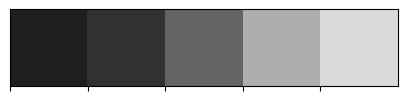

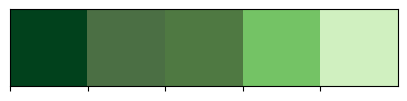

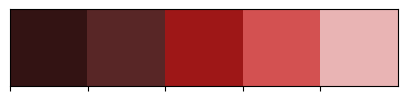

In [6]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [7]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img):

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    # Read the binary image
    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    
    # Read all contours detected
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            
            # stores the x coordinate of the character's contour, to used later for indexing the contours
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            # Draw rectangle around contour
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            
            # Display the uptated binary image with new contour
            plt.imshow(ii, cmap='gray')
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            
            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            
            # List that stores the character's binary image (unsorted)
            img_res.append(char_copy) 
            
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(img_res[idx])
        
    img_res = np.array(img_res_copy)
   
    return img_res

In [8]:
# Find characters in the resulting images and Preprocess license plate image
def segment_characters(image):
    # Resizing
    img_lp = cv2.resize(image, (233, 55))

    # Apply gray scale
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    
    # Convert to binary image
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Erode unwanted pixels
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    
    # Dilate unwanted pixels
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    
    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    
    # Estimations of character contours sizes of cropped license plates
    dimensions = [(LP_WIDTH/6) + 0.5, (LP_WIDTH/2) + 7.5, (LP_HEIGHT/10) - 15, 2 * LP_HEIGHT/3]
    
    # Visual display of binary image
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    
    # Create a binary image for next steps
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

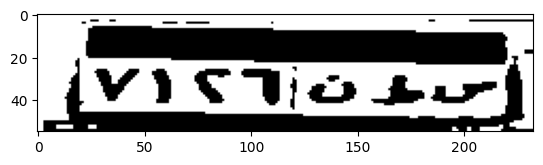

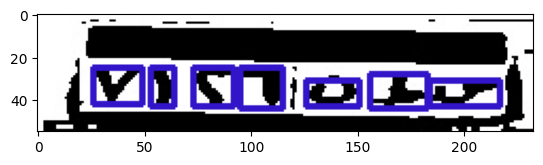

In [9]:
img = cv2.imread('D:\\car_plate_detection\\EALPR_master\\Plates_dataset\\0001_license_plate_1.png')
char = segment_characters(img)

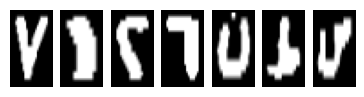

In [10]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [22]:
num_classes = 10
learning_rate = 1e-3
batch_size = 1024
num_epochs = 25

In [23]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'D:\car_plate_detection\Data Set'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/validation',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 244 images belonging to 30 classes.
Found 202 images belonging to 30 classes.


In [16]:
datagen = ImageDataGenerator()

In [17]:
class_names = ['0','1','2','3','4','5','6','7','8','9','7ah','5ah','3en','alf','bih',
          'lam','kaaf','heh','gem','feh','Excluded','dal','yeh','wow','tah','sen','sad','reh',
         'non','mem']

In [22]:
# training data
train_generator = datagen.flow_from_directory( 
    directory="D:\\car_plate_detection\\Data Set\\train", 
    classes = class_names,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode="binary", 
)

Found 244 images belonging to 30 classes.


In [23]:
# validation data
valid_generator = datagen.flow_from_directory( 
    directory="D:\\car_plate_detection\\Data Set\\validation", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 190 images belonging to 30 classes.


In [30]:
# test data
test_generator = datagen.flow_from_directory( 
    directory="D:\\car_plate_detection\\Data Set\\tes", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 124 images belonging to 30 classes.


In [31]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 271s 3us/step


In [32]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [39]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [40]:
# launch the training
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\user\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\user\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\user\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_35672\2035295664.py", line 2, in <module>
      model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")
    File "C:\Users\user\AppData\Local\Temp\ipykernel_35672\4074580862.py", line 5, in trainModel
      return model.fit(train_generator, validation_data=valid_generator, batch_size=batch_size)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 27 which is outside the valid range of [0, 5).  Label values: 27 23 20 25 2 2 11 6 17 14 21 13 2 1 5 26 3 7 27 1 10 5 3 20 1 24 27 12 1 14 4 24
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_27262]

In [ ]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()